<a href="https://colab.research.google.com/github/igedemadepradnyaairlangga/Dataanalitycs/blob/master/imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Analisis Data: Image Classification Model Deployment
- Nama: I Gede Made Pradnya Airlangga
- Email: pradnya.airlangga@gmail.com
- Id Dicoding: I Gede Made Pradnya Airlangga

Sumber Dataset : https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

## Menentukan Pertanyaan Bisnis

## Menghubungkan ke dataset yang ada di google drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [ ]:
!ls

 0t08v9bAaA0mXGCQ.png		 penjualan.csv
 alldata_1_for_kaggle.csv	 rockpaperscissors
 amazon_prime_titles.csv	 rock_paper_scissors_final_model.h5
 best_model.h5			 rock_paper_scissors_model.h5
 combined_dataset.csv		'Salinan amazon_prime_titles.csv'
 day.csv			 selic.csv
'e-shop clothing 2008.csv'	 testkt2.csv
'e-shop clothing 2008.csv.zip'	 testkt.csv
 hour.csv			 train.csv
 kaggle.json			 trainkt2.csv
 klasifikasigambar		 trainkt.csv
 klasifikasiteks		 udemy_output_All_Finance__Accounting_p1_p626.csv
 Mall_Customers.csv		 vectorizer.pkl
 OdfDTwgPVdW9XbE7.png		 world_news_in_month.csv


## Menyaipkan semua library yang dibutuhkan

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive

## Cleaning Data

In [ ]:
#Definisi path dataset
dataset_path = '/content/gdrive/My Drive/Kaggle/klasifikasigambar'

In [ ]:
# Membuat generator untuk proses augmentation dan normalisasi data
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
# Membuat train set dan test set
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 800 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [ ]:
# Membangun base model menggunakan VGG16 pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Membekukan semua layer pada base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Menambahkan layer pengklasifikasi baru di atas base model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Menggabungkan base model dan layer pengklasifikasi baru
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Menyiapkan callback untuk menyimpan model terbaik
checkpoint_path = "transfer_learning_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
# Melatih model dengan Fine-tuning
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 1.3675 - accuracy: 0.3225
Epoch 1: val_accuracy improved from -inf to 0.38542, saving model to transfer_learning_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 218s 9s/step - loss: 1.3675 - accuracy: 0.3225 - val_loss: 1.3152 - val_accuracy: 0.3854
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 1.1699 - accuracy: 0.4775
Epoch 2: val_accuracy improved from 0.38542 to 0.44792, saving model to transfer_learning_checkpoint.h5
25/25 [==============================] - 37s 1s/step - loss: 1.1699 - accuracy: 0.4775 - val_loss: 1.2008 - val_accuracy: 0.4479
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 1.0711 - accuracy: 0.5587
Epoch 3: val_accuracy improved from 0.44792 to 0.48438, saving model to transfer_learning_checkpoint.h5
25/25 [==============================] - 36s 1s/step - loss: 1.0711 - accuracy: 0.5587 - val_loss: 1.1413 - val_accuracy: 0.4844
Epoch 4/20
25/25 [==============================] - ETA: 0s - loss: 0.9841 - accuracy: 0.6062
Epoch 4: val_accuracy improved from 0.48438 to 0.55208, saving model to transfer_learning_checkpoint.h5
25/25 [===========

In [ ]:
# Menyimpan model terbaik
model.save("transfer_learning_model.h5")

In [ ]:
# Konversi model ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

59132948

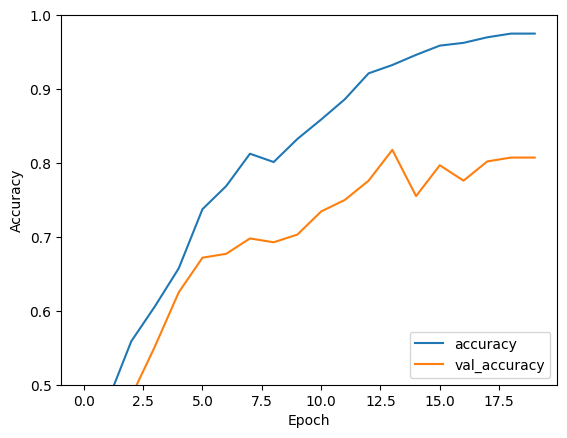

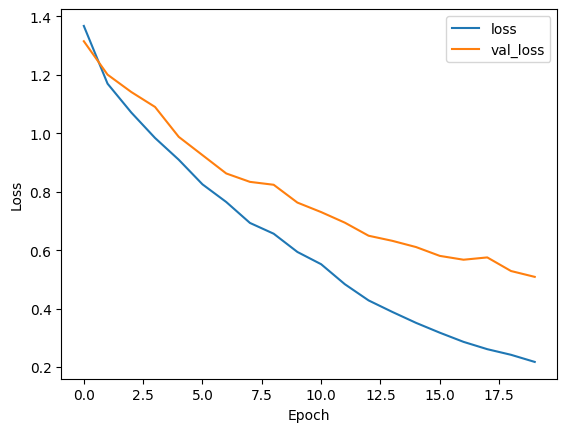

In [ ]:
# Plot akurasi dan loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

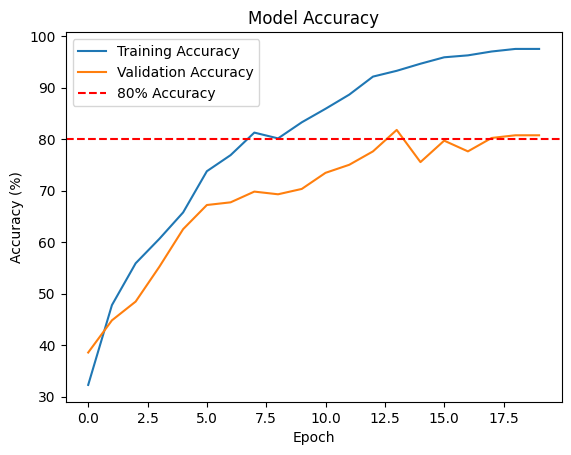

In [ ]:
# Plot akurasi dalam bentuk persen
plt.plot(np.array(history.history['accuracy']) * 100, label='Training Accuracy')
plt.plot(np.array(history.history['val_accuracy']) * 100, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')
plt.axhline(y=80, color='r', linestyle='--', label='80% Accuracy')
plt.legend()
plt.show()